In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader , TensorDataset

In [4]:
df = pd.read_csv('data.csv', encoding='latin1', engine='python', on_bad_lines='skip')


In [5]:
df

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435737,SAMP,24-12-15,West Bengal,ULUBERIA,West Bengal State Pollution Control Board,RIRUO,22.0,50.0,143.0,NaN,"Inside Rampal Industries,ULUBERIA",NaN,2015-12-24
435738,SAMP,29-12-15,West Bengal,ULUBERIA,West Bengal State Pollution Control Board,RIRUO,20.0,46.0,171.0,NaN,"Inside Rampal Industries,ULUBERIA",NaN,2015-12-29
435739,NaN,NaN,andaman-and-nicobar-islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
435740,NaN,NaN,Lakshadweep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
x = df["no2"].dropna().values
r = 102316103
ar = 0.5*(r%7)
br = 0.3*((r%5)+1)
z = x + ar*np.sin(br*x)
z = (z- np.mean(z))/np.std(z)
z

array([-0.42941614, -0.99225145,  0.15535111, ...,  1.02198733,
        1.29889978,  1.0647465 ])

In [7]:
z_real = torch.tensor(z, dtype = torch.float32).view(-1,1)
dataset = TensorDataset(z_real)
loader = DataLoader(dataset, batch_size = 129, shuffle = True)

In [8]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(1,32),
        nn.ReLU(),
        nn.Linear(32,32),
        nn.ReLU(),
        nn.Linear(32,1)
    )
  def forward(self,x):
    return self.net(x)

In [9]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(1,32),
        nn.LeakyReLU(0.2),
        nn.Linear(32,32),
        nn.LeakyReLU(0.2),
        nn.Linear(32,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.net(x)

In [11]:
G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr = 0.0002)
opt_D = torch.optim.Adam(D.parameters(), lr = 0.0002)

epoch = 500
for epoch in range(epoch):
  for(real_batch,) in loader:
    batch_len = real_batch.size(0)


    real_labels = torch.ones(batch_len,1)
    fake_labels = torch.zeros(batch_len,1)

    noise = torch.randn(batch_len,1)
    fake_batch = G(noise)

    D_real = D(real_batch)
    D_fake = D(fake_batch.detach())

    loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)
    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    fake_batch = G(noise)
    D_fake = D(fake_batch)
    loss_G = criterion(D_fake, real_labels)
    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()


  if epoch % 20 == 0:
    print(f"Epoch  {epoch} | D Loss : {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Epoch  0 | D Loss : 1.3885 | G Loss: 0.6862
Epoch  20 | D Loss : 1.3914 | G Loss: 0.7144
Epoch  40 | D Loss : 1.3902 | G Loss: 0.6876
Epoch  60 | D Loss : 1.3858 | G Loss: 0.7022
Epoch  80 | D Loss : 1.3669 | G Loss: 0.6966
Epoch  100 | D Loss : 1.4163 | G Loss: 0.6679
Epoch  120 | D Loss : 1.3948 | G Loss: 0.6775
Epoch  140 | D Loss : 1.4157 | G Loss: 0.7005
Epoch  160 | D Loss : 1.3855 | G Loss: 0.6918
Epoch  180 | D Loss : 1.3796 | G Loss: 0.6994
Epoch  200 | D Loss : 1.4308 | G Loss: 0.6877
Epoch  220 | D Loss : 1.3915 | G Loss: 0.6883
Epoch  240 | D Loss : 1.3805 | G Loss: 0.6939
Epoch  260 | D Loss : 1.4078 | G Loss: 0.6892
Epoch  280 | D Loss : 1.3851 | G Loss: 0.6938
Epoch  300 | D Loss : 1.3894 | G Loss: 0.6943
Epoch  320 | D Loss : 1.4085 | G Loss: 0.6810
Epoch  340 | D Loss : 1.3866 | G Loss: 0.7010
Epoch  360 | D Loss : 1.3844 | G Loss: 0.6900
Epoch  380 | D Loss : 1.3983 | G Loss: 0.6921
Epoch  400 | D Loss : 1.3847 | G Loss: 0.6889
Epoch  420 | D Loss : 1.4074 | G Loss: 0

In [12]:
with torch.no_grad():
  z_fake = G(torch.randn(10000,1)).numpy().flatten()

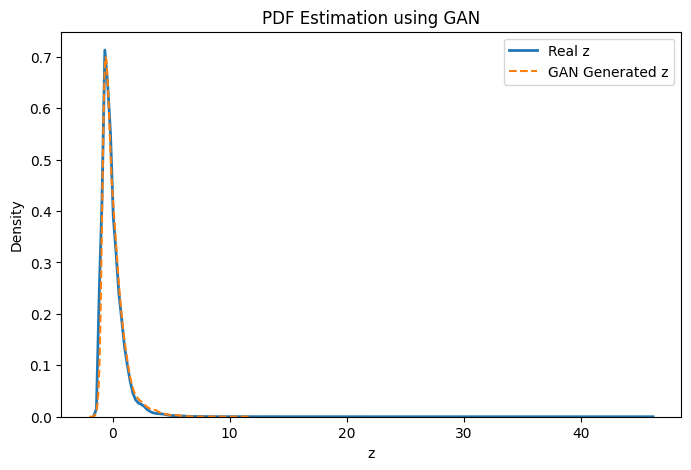

In [13]:
plt.figure(figsize = (8,5))
sns.kdeplot(z, label = "Real z", linewidth = 2)
sns.kdeplot(z_fake, label = "GAN Generated z", linestyle = "--")
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Estimation using GAN")
plt.legend()
plt.show()